In [144]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d


# for classifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

In [145]:
SGA = Table.read('SGA_Color_Params.fits')
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.29782

## T-type classification

In [146]:
# Look at morph types in SGA
unique, counts = np.unique(SGA['MORPHTYPE'], return_counts = True)
print(unique, counts)

MORPHTYPE
---------
         
  .E+..?.
  .E+..P*
  .E+4...
  .E...P*
  .I..9P.
  .IBS9..
  .L..+P*
  .L?....
  .LXS-*.
      ...
      Sab
       Sb
      Sbc
       Sc
      Scd
       Sd
       Sm
     dIrr
dIrr/dSph
     dSph
    dSph?
Length = 65 rows [     3      1      3      1      1      1      2      1      1      1
      1      1      1      2      1      1      1      1      1      1
     35   1320      1   1117      1      5  45468   3251  11137     26
   2374    118    270      1 169164    419      2   4749  14527  39252
    330    771    804    141    129    957   1492   3463   3763   3473
    783    499    459   2887   5990  11076  17294  28455   3382   2470
   1712     15      6      5      1]


In [147]:
SGA.add_column(np.nan, name='T_TYPE')

# Elliptical and dwarf ellipticals
# 45468 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'E'] = -5

# Lenticulars
# 4749
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0'] = -2
#14527
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0-a'] = 0


# Spirals
# 2887 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sa'] = 1

# 5990
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sab'] = 2

# 11076 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sb'] = 3

#17294 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sbc'] = 4

#28455 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sc'] = 5

#3382
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Scd'] = 6

#2470 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sd'] = 7

# Irregulars
#1712 + 16 + 270 + 2734 + 118
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sm'] = 9
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Irr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dIrr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'I'] = 10

# Dwarf spheroidal (5)
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dSph'] = 11

In [148]:
SGA.sort('T_TYPE')
#Get color and morph parameters on new table for random forest 
Relevant = Table([SGA['MORPHTYPE'], SGA['T_TYPE'], SGA['GRADIENT_G-Z'], SGA['GRADIENT_G-R'], SGA['GRADIENT_R-Z'], 
                 SGA['C_INDEX_R_r50_r90'], SGA['COLOR G-Z'], SGA['COLOR G-R'], SGA['COLOR R-Z']])
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z
bytes21,float64,float32,float32,float32,float32,float32,float32,float32
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426
E,-5.0,-0.53083605,-0.24365975,-0.2871763,0.20835827,1.6869307,1.0853043,0.6016264
E,-5.0,-0.09060609,-0.04634577,-0.044260323,0.17891355,1.5189896,0.9096937,0.60929585
E,-5.0,-0.105971575,-0.09282738,-0.013144195,0.14360416,1.7361784,1.0164785,0.71969986
E,-5.0,-0.66179395,-0.25598752,-0.40580642,0.24141927,1.4583244,0.9870472,0.47127724
E,-5.0,--,--,--,0.14834835,--,--,--
E,-5.0,-0.42369863,-0.16379105,-0.2599076,0.2522917,1.7391319,1.0215645,0.71756744
E,-5.0,-0.089765996,-0.04370889,-0.046057105,0.19391565,1.5149117,0.86676025,0.6481514
E,-5.0,-0.108296275,0.006925285,-0.11522156,0.19418615,1.7074795,0.9784012,0.7290783


In [149]:
# Group by ellipticals, spirals, lenticulars and irregulars (no barred galaxies)
Relevant.add_column('Undefined', name='TYPE')

spirals = [1, 2, 3, 4, 5, 6, 7]
for i in spirals:
    Relevant['TYPE'][Relevant['T_TYPE'] == i] = 'Spirals'

Relevant['TYPE'][Relevant['T_TYPE'] == -5] = 'Elliptic'

Relevant['TYPE'][Relevant['T_TYPE'] == -2] = 'Len'
Relevant['TYPE'][Relevant['T_TYPE'] == 0] = 'Len'

Relevant['TYPE'][Relevant['T_TYPE'] == 10] = 'Irregular'
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,Elliptic
E,-5.0,-0.53083605,-0.24365975,-0.2871763,0.20835827,1.6869307,1.0853043,0.6016264,Elliptic
E,-5.0,-0.09060609,-0.04634577,-0.044260323,0.17891355,1.5189896,0.9096937,0.60929585,Elliptic
E,-5.0,-0.105971575,-0.09282738,-0.013144195,0.14360416,1.7361784,1.0164785,0.71969986,Elliptic
E,-5.0,-0.66179395,-0.25598752,-0.40580642,0.24141927,1.4583244,0.9870472,0.47127724,Elliptic
E,-5.0,--,--,--,0.14834835,--,--,--,Elliptic
E,-5.0,-0.42369863,-0.16379105,-0.2599076,0.2522917,1.7391319,1.0215645,0.71756744,Elliptic
E,-5.0,-0.089765996,-0.04370889,-0.046057105,0.19391565,1.5149117,0.86676025,0.6481514,Elliptic
E,-5.0,-0.108296275,0.006925285,-0.11522156,0.19418615,1.7074795,0.9784012,0.7290783,Elliptic


In [150]:
Relevant[Relevant['TYPE'] == 'Undefined']

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
Sm,9.0,0.13640028,0.08762047,0.048779815,0.38616866,0.60614777,0.39414024,0.21200752,Undefined
Sm,9.0,-0.449233,-0.19035956,-0.2588734,0.46027014,1.650197,0.9114666,0.73873043,Undefined
Sm,9.0,0.1740165,-0.043727018,0.21774352,0.3629024,0.56702614,0.35326576,0.21376038,Undefined
Sm,9.0,-1.797117,-0.030591369,-1.7665257,0.36293313,0.017069817,0.52635384,-0.509284,Undefined
Sm,9.0,-0.09330261,-0.059972107,-0.0333305,0.22553946,0.63246346,0.37584305,0.2566204,Undefined
Sm,9.0,-0.45281002,-0.19200471,-0.2608053,0.4796629,0.99346447,0.5483074,0.44515705,Undefined
Sm,9.0,-0.03318411,0.040005207,-0.07318932,0.35463876,1.0146904,0.65372086,0.36096954,Undefined
Sm,9.0,0.03064166,-0.0003348291,0.03097649,0.25801355,1.6983585,0.9874401,0.7109184,Undefined
Sm,9.0,-0.85645294,-0.25972873,-0.59672415,0.53215104,1.5123043,0.8940582,0.6182461,Undefined


In [151]:
Relevant[Relevant['TYPE'] == 'Undefined']
n = len(Relevant[Relevant['TYPE'] == 'Undefined'])

In [152]:
Relevant.sort('TYPE')
Relevant.remove_rows([range((len(Relevant) - n),len(Relevant))])
Relevant

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/astropy/table/table.py:2750: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,Elliptic
E,-5.0,--,--,--,--,--,--,--,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,Elliptic


In [153]:
filtering_for_classifier = np.logical_not(Relevant['GRADIENT_G-Z'].mask)& np.logical_not(Relevant['GRADIENT_G-R'].mask)& np.logical_not(Relevant['GRADIENT_R-Z'].mask) & np.logical_not(Relevant['C_INDEX_R_r50_r90'].mask)& np.logical_not(Relevant['COLOR G-Z'].mask) & np.logical_not(Relevant['COLOR G-R'].mask)& np.logical_not(Relevant['COLOR R-Z'].mask)
Data = Relevant[filtering_for_classifier]
Data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,Elliptic
E,-5.0,-0.10071872,-0.08763887,-0.013079852,0.23602146,1.5228395,0.8931446,0.62969494,Elliptic


In [154]:
unique, counts = np.unique(Data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [41879  2097 18019 67621]


In [155]:
# Get equal samples for all general types of galaxies, in this case take min. value of 3975 for each
sample_elliptical = Data[Data['TYPE'] == 'Elliptic'][:2097]
sample_lenticular = Data[Data['TYPE'] == 'Len'][:2097]
sample_spirals = Data[Data['TYPE'] == 'Spirals'][:2097]
sample_irregular = Data[Data['TYPE'] == 'Irregular']
new_data = vstack([sample_elliptical, sample_lenticular, sample_spirals, sample_irregular])
new_data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,Elliptic
E,-5.0,-0.10071872,-0.08763887,-0.013079852,0.23602146,1.5228395,0.8931446,0.62969494,Elliptic


In [156]:
unique, counts = np.unique(new_data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [2097 2097 2097 2097]


## Random forest (with barred galaxies as their respective spiral categories)

In [157]:
# Determine the correct shapes of the array
N = len(new_data)
X = np.zeros((N,7)) 

# Basically copying columns to associate later
X[:,0]= new_data['GRADIENT_G-Z']
X[:,1]= new_data['GRADIENT_G-R']
X[:,2]= new_data['GRADIENT_R-Z']
X[:,3]= new_data['C_INDEX_R_r50_r90']
X[:,4]= new_data['COLOR G-Z']
X[:,5]= new_data['COLOR G-R']
X[:,6]= new_data['COLOR R-Z']

# Target data array
y = np.array(new_data['TYPE'])
print(X.size, y.size)

58716 8388


In [158]:
# Train and test data samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train.shape, X_test.shape

((5032, 7), (3356, 7))

In [159]:
y_train.shape, y_test.shape

((5032,), (3356,))

In [160]:
# create random forest
random_forest_100 = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set
classification_fit = random_forest_100.fit(X_train, y_train)

# Predict on the test set results
y_pred = random_forest_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
accuracy = accuracy_score(y_test, y_pred,normalize=False)
print('Correctly classified points =', accuracy)

Model accuracy score with 100 decision trees : 0.6952
Correctly classified points = 2333


In [161]:
# Evaluate the classifier
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Elliptic       0.68      0.57      0.62       858
   Irregular       0.81      0.82      0.81       810
         Len       0.55      0.64      0.59       819
     Spirals       0.76      0.75      0.75       869

    accuracy                           0.70      3356
   macro avg       0.70      0.70      0.70      3356
weighted avg       0.70      0.70      0.70      3356



In [162]:
feature_scores = random_forest_100.feature_importances_
feature_scores

array([0.0974557 , 0.12216632, 0.09342998, 0.17250789, 0.16849205,
       0.19444431, 0.15150375])

In [163]:
feature_scores = random_forest_100.feature_importances_

# from values
#X[:,0]= Data['GRADIENT_G-Z']
#X[:,1]= Data['GRADIENT_G-R']
#X[:,2]= Data['GRADIENT_R-Z']
#X[:,3]= Data['C_INDEX_R_r50_r90']
#X[:,4]= Data['COLOR G-Z']
#X[:,5]= Data['COLOR G-R']
#X[:,6]= Data['COLOR R-Z']

array = np.array([['Gradient_G-Z', feature_scores[0]], ['Gradient_G-R',  feature_scores[1]], 
                  ['Gradient_R_Z', feature_scores[2]], ['C_INDEX_R_r50_r90', feature_scores[3]],  
                  ['COLOR G-Z', feature_scores[4]], ['COLOR G-R', feature_scores[5]], ['COLOR R-Z', feature_scores[6]]]) 

column_values = ['Parameters', 'Feature_Scores'] 

index_values = [1, 2, 3, 4, 5, 6, 7] 

Feature_scores = pd.DataFrame(data = array,  
                  index = index_values,  
                  columns = column_values) 
  
# displaying the dataframe 
Feature_scores.sort_values(by=['Feature_Scores'], ascending=False)

,Parameters,Feature_Scores
6,COLOR G-R,0.19444431085024066
4,C_INDEX_R_r50_r90,0.17250789360637692
5,COLOR G-Z,0.16849205479213122
7,COLOR R-Z,0.15150374647805842
2,Gradient_G-R,0.12216631611189153
1,Gradient_G-Z,0.09745570293787263
3,Gradient_R_Z,0.09342997522342872


## Confusion matrix

In [164]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[493  35 292  38]
 [  6 662  41 101]
 [203  21 524  71]
 [ 18 102  95 654]]


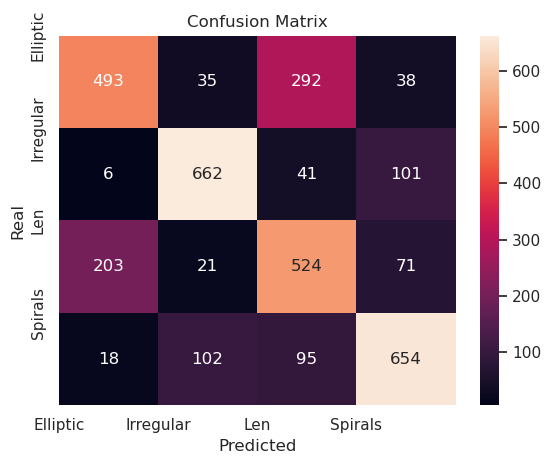

In [165]:
# Visualizing confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))

plt.show()

In [166]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
poisson = np.sqrt(cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.57459207, 0.04079254, 0.34032634, 0.04428904],
       [0.00740741, 0.81728395, 0.05061728, 0.12469136],
       [0.24786325, 0.02564103, 0.63980464, 0.08669109],
       [0.02071346, 0.11737629, 0.10932106, 0.75258918]])

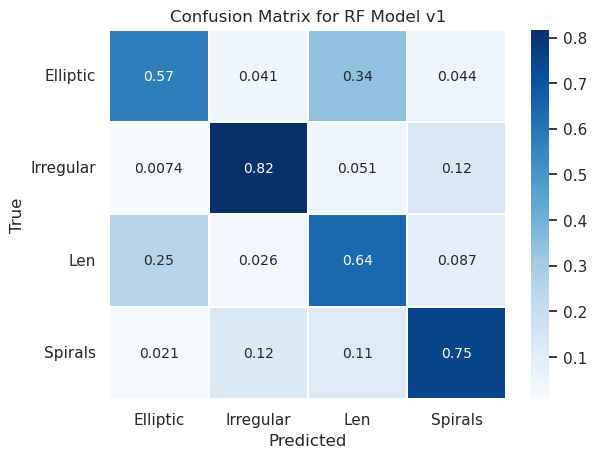

In [167]:
# Get and reshape confusion matrix data
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#poisson = np.sqrt(cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]

# Build the plot
sns.set(font_scale=1.0)
sns.heatmap(cm, annot=True, annot_kws={'size':10}, linewidths=0.2, cmap = 'Blues')

# Add labels to the plot
class_names = ['Elliptic', 'Irregular', 'Len', 'Spirals']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks + 0.5, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF Model v1')
plt.show()